In [148]:
#pip install sodapy

In [149]:
from sodapy import Socrata
import pandas as pd
#from google.colab import drive
import re

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Exploratory Data Analysis on the NYC 311 Service request open data

By: Oscar E. Gallardo

This data analysis project is to explore the open data of NYC 311 Service Requests. In this project I explore the data based on several attributes/columns to create informative visuals. I examine the top complaint that is called in and in each borough. I analyze which community board is most affected by heat or hot water issues based on the frequency in those complaints in each community board. I also analyze frequency of total calls by hour and agency.  

### API

In [151]:
# We request the 150,000 most recent 311 service request calls made

In [152]:
client = Socrata("data.cityofnewyork.us", None)

client.timeout = 1000
results = client.get("erm2-nwe9", limit=150000)

In [153]:
# Creating a DataFrame from client results using pandas library
df = pd.DataFrame.from_records(results)

In [154]:
# Getting information on the attributes/columns in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 46 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   unique_key                      150000 non-null  object
 1   created_date                    150000 non-null  object
 2   agency                          150000 non-null  object
 3   agency_name                     150000 non-null  object
 4   complaint_type                  150000 non-null  object
 5   descriptor                      148896 non-null  object
 6   location_type                   130353 non-null  object
 7   incident_zip                    147743 non-null  object
 8   incident_address                142378 non-null  object
 9   street_name                     142374 non-null  object
 10  cross_street_1                  90386 non-null   object
 11  cross_street_2                  90390 non-null   object
 12  intersection_street_1         

In [155]:
df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,...,bbl,closed_date,resolution_description,resolution_action_updated_date,facility_type,taxi_pick_up_location,taxi_company_borough,road_ramp,due_date,vehicle_type
0,53113076,2022-01-20T00:59:59.000,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Music,Street/Sidewalk,11355,58-60 COLLEGE POINT BOULEVARD,COLLEGE POINT BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53115067,2022-01-20T00:59:48.000,NYPD,New York City Police Department,Encampment,N/A,Subway,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53113009,2022-01-20T00:59:48.000,NYPD,New York City Police Department,Noise - Park,Loud Music/Party,Park/Playground,11368,FLUSHING MEADOWS CORONA PARK,FLUSHING MEADOWS CORONA PARK,...,4020180001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,53112813,2022-01-20T00:58:48.000,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11379,74-07 ELIOT AVENUE,ELIOT AVENUE,...,4028440046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53115523,2022-01-20T00:56:57.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11103,30-91 STEINWAY STREET,STEINWAY STREET,...,4006800009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
# check null values
df.isnull().sum()

unique_key                             0
created_date                           0
agency                                 0
agency_name                            0
complaint_type                         0
descriptor                          1104
location_type                      19647
incident_zip                        2257
incident_address                    7622
street_name                         7626
cross_street_1                     59614
cross_street_2                     59610
intersection_street_1              65274
intersection_street_2              65203
address_type                        1333
city                                6455
landmark                           75771
status                                 0
community_board                        0
borough                                0
x_coordinate_state_plane            1930
y_coordinate_state_plane            1904
open_data_channel_type                 0
park_facility_name                     0
park_borough    

In [157]:
#exclude unnecessary columns
df = df[['unique_key', 'created_date', 'complaint_type', 'agency', 'agency_name', 'community_board', 
         'latitude', 'longitude', 'descriptor', 'borough', 'incident_zip', 'incident_address', 'street_name', 'city', 'status','resolution_description', 'resolution_action_updated_date', 'closed_date']]

In [158]:
df.head()

,unique_key,created_date,complaint_type,agency,agency_name,community_board,latitude,longitude,descriptor,borough,incident_zip,incident_address,street_name,city,status,resolution_description,resolution_action_updated_date,closed_date
0,53113076,2022-01-20T00:59:59.000,Noise - Vehicle,NYPD,New York City Police Department,81 QUEENS,40.74499762553621,-73.83578107103398,Car/Truck Music,QUEENS,11355,58-60 COLLEGE POINT BOULEVARD,COLLEGE POINT BOULEVARD,FLUSHING,In Progress,NaN,NaN,NaN
1,53115067,2022-01-20T00:59:48.000,Encampment,NYPD,New York City Police Department,Unspecified MANHATTAN,40.72340051149166,-73.98993807355491,N/A,MANHATTAN,NaN,NaN,NaN,NaN,In Progress,NaN,NaN,NaN
2,53113009,2022-01-20T00:59:48.000,Noise - Park,NYPD,New York City Police Department,81 QUEENS,40.742377064999275,-73.84215697754966,Loud Music/Party,QUEENS,11368,FLUSHING MEADOWS CORONA PARK,FLUSHING MEADOWS CORONA PARK,CORONA,In Progress,NaN,NaN,NaN
3,53112813,2022-01-20T00:58:48.000,Illegal Parking,NYPD,New York City Police Department,05 QUEENS,40.72209241523063,-73.8855076657382,Commercial Overnight Parking,QUEENS,11379,74-07 ELIOT AVENUE,ELIOT AVENUE,MIDDLE VILLAGE,In Progress,NaN,NaN,NaN
4,53115523,2022-01-20T00:56:57.000,Noise - Residential,NYPD,New York City Police Department,01 QUEENS,40.76184945410408,-73.9166460740125,Loud Music/Party,QUEENS,11103,30-91 STEINWAY STREET,STEINWAY STREET,ASTORIA,In Progress,NaN,NaN,NaN


In [159]:
df.complaint_type.unique()

array(['Noise - Vehicle', 'Encampment', 'Noise - Park', 'Illegal Parking',
       'Noise - Residential', 'Blocked Driveway', 'Rodent',
       'Noise - Street/Sidewalk', 'Food Establishment',
       'Illegal Fireworks', 'Dirty Condition', 'Consumer Complaint',
       'Noise - Commercial', 'Abandoned Vehicle', 'Non-Residential Heat',
       'Traffic', 'Street Condition', 'Non-Emergency Police Matter',
       'Missed Collection', 'Outdoor Dining', 'Curb Condition',
       'WATER LEAK', 'APPLIANCE', 'Noise', 'HEAT/HOT WATER',
       'Panhandling', 'New Tree Request', 'For Hire Vehicle Complaint',
       'Air Quality', 'Illegal Dumping',
       'Sanitation Worker or Vehicle Complaint', 'Water System',
       'Sidewalk Condition', 'UNSANITARY CONDITION',
       'Broken Parking Meter', 'PLUMBING', 'Dead Animal',
       'Street Sign - Missing', 'School Maintenance', 'Graffiti',
       'GENERAL', 'Lead', 'ELECTRIC', 'Drinking', 'Drug Activity',
       'Root/Sewer/Sidewalk Condition', 'PAINT/PLA

In [160]:
df.agency.unique()

array(['NYPD', 'DOHMH', 'DSNY', 'DCA', 'DOT', 'HPD', 'DEP', 'DPR', 'TLC',
       'DHS', 'DOE', 'EDC', 'DOB',
       'MAYORâ\x80\x99S OFFICE OF SPECIAL ENFORCEMENT', 'DFTA', 'DOITT'],
      dtype=object)

In [161]:
def update_OSE(agency):
  """Takes in an agency name and converts to abbreviated form, if the agency is
     the Office of Special Enforcement."""

  if agency == 'MAYORâ\x80\x99S OFFICE OF SPECIAL ENFORCEMENT':
      return "OSE"
  else:
      return agency
    
df.agency = df.agency.map(lambda agency: update_OSE(agency))

In [162]:
noise_columns = []

for i in df.complaint_type:
   if i.startswith('Noise') and i not in noise_columns:
     noise_columns.append(i)
noise_columns

['Noise - Vehicle',
 'Noise - Park',
 'Noise - Residential',
 'Noise - Street/Sidewalk',
 'Noise - Commercial',
 'Noise',
 'Noise - Helicopter',
 'Noise - House of Worship']

In [163]:
#Label unspecified noise complaints as 'Noise - Unspecified'
# Takes in an complaint name and updates it, if it is an unspecified noise complaint.
def update_noise(complaint):
  if complaint == 'Noise':
    return "Noise - Unspecified"
  else:
    return complaint
    
df.complaint_type = df.complaint_type.map(
    lambda complaint: update_noise(complaint))

In [164]:
type(df.created_date[1])

str

In [165]:
#convert date column to datetime 
df['created_date'] = pd.to_datetime(df['created_date'], 
                                    format='%Y-%m-%dT%H:%M:%S.%f')

In [166]:
#check new data type for created_date column
type(df['created_date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [167]:
# create new columns with the day, month, day of week, and hour of each call. 
# This will allow us to explore the independent relationship of each variable to other characteristics of the calls.

In [168]:
df['day'] = [str(i.date()) for i in df.created_date]
df['month'] = [int(i.month) for i in df.created_date]
df['day_of_week'] = [int(i.weekday()) for i in df.created_date]
df['hour'] = [int(i.hour) for i in df.created_date]

In [169]:
df['day'].unique()

array(['2022-01-20', '2022-01-19', '2022-01-18', '2022-01-17',
       '2022-01-16', '2022-01-15', '2022-01-14', '2022-01-13',
       '2022-01-12', '2022-01-11', '2022-01-10', '2022-01-09',
       '2022-01-08', '2022-01-07', '2022-01-06', '2022-01-05',
       '2022-01-04', '2022-01-03', '2022-01-02', '2022-01-01',
       '2021-12-31', '2021-12-30'], dtype=object)

In [170]:
df[df['day'] == '2022-01-14']

,unique_key,created_date,complaint_type,agency,agency_name,community_board,latitude,longitude,descriptor,borough,...,street_name,city,status,resolution_description,resolution_action_updated_date,closed_date,day,month,day_of_week,hour
39819,53061590,2022-01-14 23:59:46,Illegal Parking,NYPD,New York City Police Department,03 BROOKLYN,40.6791471172615,-73.93848595157297,Blocked Hydrant,BROOKLYN,...,ALBANY AVENUE,BROOKLYN,Closed,The Police Department issued a summons in resp...,2022-01-15T00:39:08.000,2022-01-15T00:39:01.000,2022-01-14,1,4,23
39820,53063610,2022-01-14 23:59:33,Noise - Residential,NYPD,New York City Police Department,09 BRONX,40.83261900218038,-73.87628697544656,Banging/Pounding,BRONX,...,STRATFORD AVENUE,BRONX,Closed,The Police Department responded to the complai...,2022-01-15T00:06:30.000,2022-01-15T00:06:24.000,2022-01-14,1,4,23
39821,53056660,2022-01-14 23:59:08,Illegal Parking,NYPD,New York City Police Department,03 BROOKLYN,40.69395070129018,-73.94600909609325,Blocked Hydrant,BROOKLYN,...,TOMPKINS AVENUE,BROOKLYN,Closed,The Police Department responded to the complai...,2022-01-15T00:08:20.000,2022-01-15T00:08:15.000,2022-01-14,1,4,23
39822,53061034,2022-01-14 23:59:00,Street Light Condition,DOT,Department of Transportation,11 BROOKLYN,40.605970023206524,-73.98409273729172,Street Light Out,BROOKLYN,...,WEST 11 STREET,BROOKLYN,Open,NaN,NaN,NaN,2022-01-14,1,4,23
39823,53056241,2022-01-14 23:58:54,Rodent,DOHMH,Department of Health and Mental Hygiene,12 MANHATTAN,40.868267734000455,-73.92455372965492,Mouse Sighting,MANHATTAN,...,SEAMAN AVENUE,NEW YORK,In Progress,NaN,NaN,NaN,2022-01-14,1,4,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47118,53062641,2022-01-14 00:00:32,HEAT/HOT WATER,HPD,Department of Housing Preservation and Develop...,10 MANHATTAN,40.81771010223045,-73.93821697256283,APARTMENT ONLY,MANHATTAN,...,LENOX AVENUE,NEW YORK,Closed,The complaint you filed is a duplicate of a co...,2022-01-15T00:00:00.000,2022-01-15T11:58:22.000,2022-01-14,1,4,0
47119,53055449,2022-01-14 00:00:25,Street Sign - Missing,DOT,Department of Transportation,07 QUEENS,40.77519113101208,-73.79852896378222,Other/Unknown,QUEENS,...,24 ROAD,NaN,In Progress,The Department of Transportation inspected the...,2022-01-14T09:15:25.000,NaN,2022-01-14,1,4,0
47120,53052964,2022-01-14 00:00:16,Blocked Driveway,NYPD,New York City Police Department,11 BRONX,40.868574991645396,-73.86437176637796,Partial Access,BRONX,...,WALLACE AVENUE,BRONX,Closed,The Police Department issued a summons in resp...,2022-01-14T01:48:38.000,2022-01-14T01:48:33.000,2022-01-14,1,4,0
47121,53053243,2022-01-14 00:00:13,Noise - Vehicle,NYPD,New York City Police Department,10 MANHATTAN,40.805032463482874,-73.95682044265718,Car/Truck Music,MANHATTAN,...,MANHATTAN AVENUE,NaN,Closed,The Police Department responded to the complai...,2022-01-14T00:54:09.000,2022-01-14T00:54:04.000,2022-01-14,1,4,0


In [171]:
df.agency.value_counts()

NYPD     56636
HPD      47463
DSNY     10865
DOT      10442
DEP       8382
DOHMH     4979
DOB       3717
DPR       2682
DHS       1625
EDC       1174
TLC        931
DCA        919
DOE         93
OSE         67
DFTA        21
DOITT        4
Name: agency, dtype: int64

### Exploratory Data Analysis

#### Total Calls by Hour and Agency

In [172]:
def hour_call_freq_df(agency):

  """Takes in an agency name as a string. Returns a dataframe with agencies 
     and the total number of calls related to the given agency that were made 
     at each hour of the day."""

  subset = df[df.agency==agency]
    
  call_freqs_by_hour = {}
    
  for hour in subset.hour:
    
      if hour not in call_freqs_by_hour: 
            call_freqs_by_hour[hour] = 1
        
      else:
            call_freqs_by_hour[hour] += 1
  
  freq_df = pd.DataFrame.from_dict(call_freqs_by_hour, orient='index',
                                   columns=['{}'.format(agency)])
    
  return freq_df.sort_index()

In [173]:
NYPD = hour_call_freq_df('NYPD')
HPD = hour_call_freq_df('HPD')
DPR = hour_call_freq_df('DPR')
DOT = hour_call_freq_df('DOT')
DEP = hour_call_freq_df('DEP')
DSNY = hour_call_freq_df('DSNY')

In [174]:
NYPD.head()

,NYPD
0,3158
1,2312
2,1520
3,1134
4,971


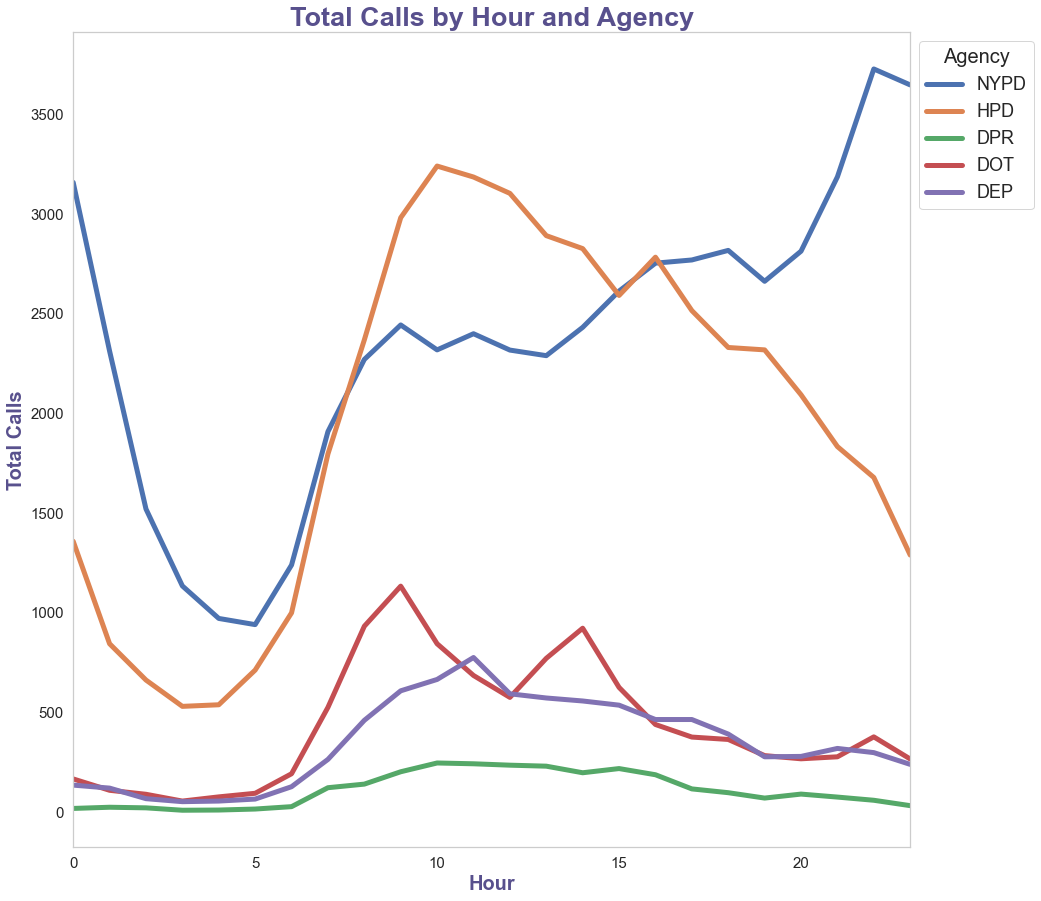

In [175]:
font_dict = dict(size=20, color="#58508d", fontweight='bold')
title_font_dict = dict(size=27, color="#58508d", fontweight='bold')

plt.figure(figsize=(15, 15))
plt.plot(NYPD.index, NYPD.NYPD, label="NYPD", linewidth=5)
plt.plot(HPD.index, HPD.HPD, label="HPD", linewidth=5)
plt.plot(DPR.index, DPR.DPR, label="DPR", linewidth=5)
plt.plot(DOT.index, DOT.DOT, label="DOT", linewidth=5)
plt.plot(DEP.index, DEP.DEP, label="DEP", linewidth=5)
plt.ylabel('Total Calls', fontdict=font_dict)
plt.xlabel('Hour', fontdict=font_dict)
plt.title('Total Calls by Hour and Agency', fontdict=title_font_dict)
plt.legend(title="Agency", title_fontsize=20, fontsize=18, 
           bbox_to_anchor=[1,1]) #position legend outside of plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(right=23) 
plt.xlim(left=0) 
plt.grid()

### Call Volume by Complaint Type and Date

In [176]:
df.complaint_type.value_counts()

HEAT/HOT WATER                36989
Illegal Parking               18071
Noise - Residential           14504
Blocked Driveway               7885
Water System                   3206
                              ...  
Cooling Tower                     1
Recycling Basket Complaint        1
Retailer Complaint                1
Oil or Gas Spill                  1
X-Ray Machine/Equipment           1
Name: complaint_type, Length: 161, dtype: int64

In [177]:
## Using top complaint types

In [178]:
def date_call_freq_df(complaint_type):
  """Takes in a complaint type as a string. Returns a dataframe with dates 
     and the total number of calls related to the given complaint that were made 
     on each date."""
    
  subset = df[df.complaint_type==complaint_type]  
  call_freqs_by_date = {}
    
  for date in subset.day:
      if date not in call_freqs_by_date: 
            call_freqs_by_date[date] = 1
      else:
            call_freqs_by_date[date] += 1
    
  freq_df = pd.DataFrame.from_dict(call_freqs_by_date, orient='index', 
                                   columns=['{}'.format(complaint_type)])
  return freq_df.sort_index()

In [179]:
# call frequency dataframes for top 5 complaint types
heat_hot_water_Date = date_call_freq_df('HEAT/HOT WATER')
illegal_parking_Date = date_call_freq_df('Illegal Parking')
noise_residential_Date = date_call_freq_df('Noise - Residential')
blocked_driveway_Date = date_call_freq_df('Blocked Driveway')
noise_street_Date = date_call_freq_df('Noise - Street/Sidewalk')

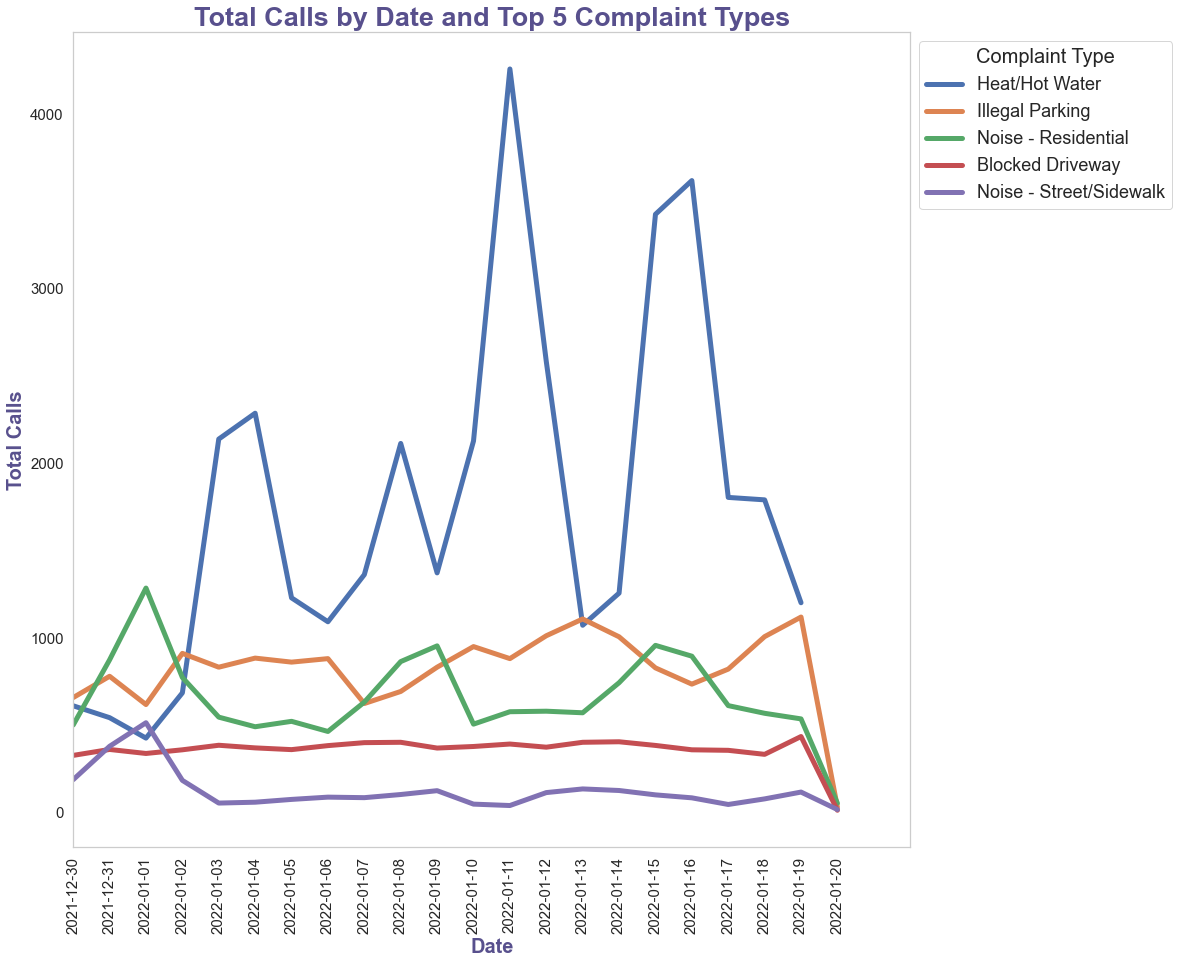

In [180]:
font_dict = dict(size=20, color="#58508d", fontweight='bold')
title_font_dict = dict(size=27, color="#58508d", fontweight='bold')

plt.figure(figsize=(15, 15))
plt.plot(heat_hot_water_Date.index, heat_hot_water_Date['HEAT/HOT WATER'], label="Heat/Hot Water", linewidth=5)
plt.plot(illegal_parking_Date.index, illegal_parking_Date['Illegal Parking'], label="Illegal Parking", linewidth=5)
plt.plot(noise_residential_Date.index, noise_residential_Date['Noise - Residential'], label="Noise - Residential", linewidth=5)
plt.plot(blocked_driveway_Date.index, blocked_driveway_Date['Blocked Driveway'], label="Blocked Driveway", linewidth=5)
plt.plot(noise_street_Date.index, noise_street_Date['Noise - Street/Sidewalk'], label="Noise - Street/Sidewalk", linewidth=5)
plt.ylabel('Total Calls', fontdict=font_dict)
plt.xlabel('Date', fontdict=font_dict)
plt.title('Total Calls by Date and Top 5 Complaint Types', fontdict=title_font_dict)
plt.legend(title="Complaint Type", title_fontsize=20, fontsize=18, 
           bbox_to_anchor=[1,1]) #position legend outside of plot
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.xlim(right=23) 
plt.xlim(left=0) 
plt.grid()

## - From 12-21-2021 - 01-13-2022

Analysis - 
This graph shows the frequency of calls within the last 15 days based on the top 5 complaint types in this dataset. It shows that Heat/Hot water complaints lead any other complaint type and has peaked numerous times within the last 15 days. This analysis should take into consideration that we are taking the 150,000 most recent 311 service request calls and that it being winter season at the time of this data request is the reason of peak in Heat/Hot Water complaints.

### Top 5 Complaint Types Frequency by Hour

In [181]:
def hour_complaint_freq_df(complaint_type):
  """Takes in a complaint type as a string. Returns a dataframe with dates 
     and the total number of calls related to the given complaint that were made 
     on each date."""
    
  subset = df[df.complaint_type==complaint_type]  
  call_freqs_by_hour = {}
    
  for hour in subset.hour:
      if hour not in call_freqs_by_hour: 
            call_freqs_by_hour[hour] = 1
      else:
            call_freqs_by_hour[hour] += 1
    
  freq_df = pd.DataFrame.from_dict(call_freqs_by_hour, orient='index', 
                                   columns=['{}'.format(complaint_type)])
  return freq_df.sort_index()

In [182]:
# call frequency dataframes for top 5 complaint types
heat_hot_water = hour_complaint_freq_df('HEAT/HOT WATER')
illegal_parking = hour_complaint_freq_df('Illegal Parking')
noise_residential = hour_complaint_freq_df('Noise - Residential')
blocked_driveway = hour_complaint_freq_df('Blocked Driveway')
noise_street = hour_complaint_freq_df('Noise - Street/Sidewalk')

In [183]:
# checking frequency dataframes
heat_hot_water.head(5)

,HEAT/HOT WATER
0,1155
1,729
2,579
3,448
4,462


In [184]:
heat_hot_water.shape

(24, 1)

In [185]:
noise_residential.head()

,Noise - Residential
0,1320
1,988
2,720
3,532
4,433


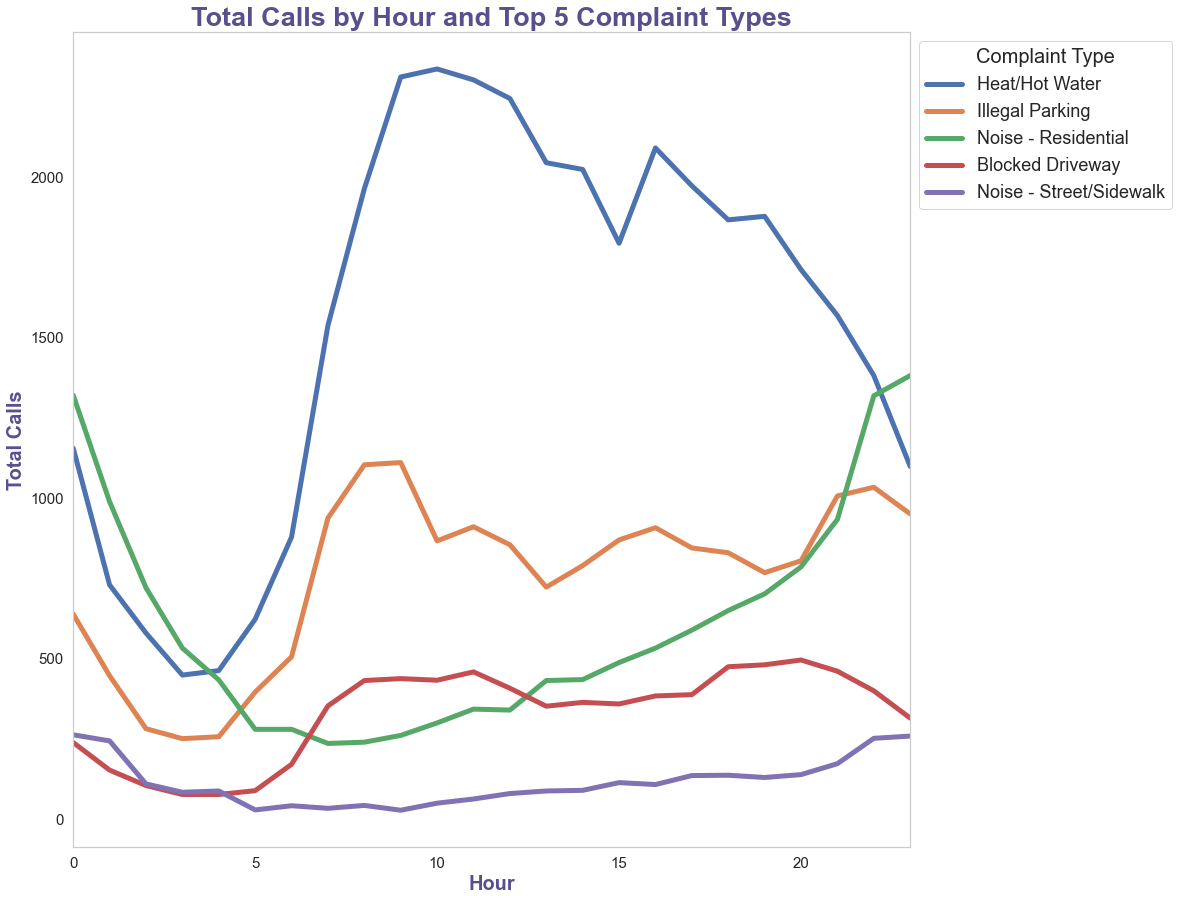

In [186]:
font_dict = dict(size=20, color="#58508d", fontweight='bold')
title_font_dict = dict(size=27, color="#58508d", fontweight='bold')

plt.figure(figsize=(15, 15))
plt.plot(heat_hot_water.index, heat_hot_water['HEAT/HOT WATER'], label="Heat/Hot Water", linewidth=5)
plt.plot(illegal_parking.index, illegal_parking['Illegal Parking'], label="Illegal Parking", linewidth=5)
plt.plot(noise_residential.index, noise_residential['Noise - Residential'], label="Noise - Residential", linewidth=5)
plt.plot(blocked_driveway.index, blocked_driveway['Blocked Driveway'], label="Blocked Driveway", linewidth=5)
plt.plot(noise_street.index, noise_street['Noise - Street/Sidewalk'], label="Noise - Street/Sidewalk", linewidth=5)
plt.ylabel('Total Calls', fontdict=font_dict)
plt.xlabel('Hour', fontdict=font_dict)
plt.title('Total Calls by Hour and Top 5 Complaint Types', fontdict=title_font_dict)
plt.legend(title="Complaint Type", title_fontsize=20, fontsize=18, 
           bbox_to_anchor=[1,1]) #position legend outside of plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(right=23) 
plt.xlim(left=0) 
plt.grid()


Analysis - 
This visual shows the rate(total Calls) and time(hour) in which calls of the top 5 complaint types are made. 

### Areas with Highest Number of Heat/Hot Water Complaints

In [187]:
## filter dataframe for only Heat/Hot Water Complaints
## Plot by County - bar plot
heat_complaint = df[df['complaint_type'] == 'HEAT/HOT WATER']
heat_complaint = heat_complaint.groupby('community_board').size().to_frame('size')

In [188]:
heat_complaint = heat_complaint.sort_values(by=['size'],ascending=False)
heat_complaint

,size
community_board,
12 MANHATTAN,2315
07 BRONX,2163
05 BRONX,1957
04 BRONX,1899
10 MANHATTAN,1532
...,...
02 STATEN ISLAND,68
03 STATEN ISLAND,61
01 MANHATTAN,21


In [189]:
heat_complaint = heat_complaint.iloc[0:10]
heat_complaint

,size
community_board,
12 MANHATTAN,2315
07 BRONX,2163
05 BRONX,1957
04 BRONX,1899
10 MANHATTAN,1532
09 BRONX,1326
14 BROOKLYN,1216
09 BROOKLYN,1081
12 BRONX,1046


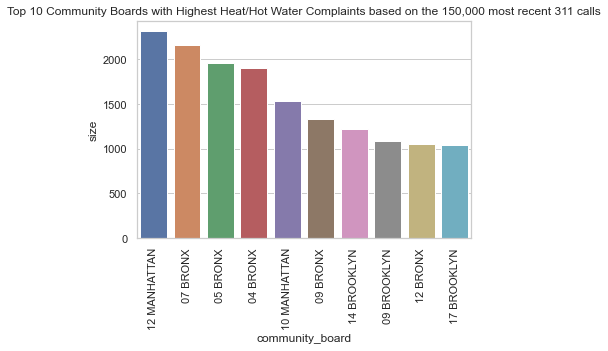

In [190]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=heat_complaint.index, y=heat_complaint['size'])
ax.set_title('Top 10 Community Boards with Highest Heat/Hot Water Complaints based on the 150,000 most recent 311 calls')
ax.tick_params(axis='x', rotation=90)

Analysis - 
Do to current News reports about heat housing issues during this winter season, I analyzed which community boards are more affected. It shows that 12 Manhattan community board had the highest rate of 311 service request calls concerning Heat/Water complaints.

### Areas/County and their most frequent complaint type

In [191]:
lead_complaint = df.groupby(['borough','complaint_type']).size().to_frame('size')
lead_complaint = lead_complaint.reset_index()
lead_complaint

,borough,complaint_type,size
0,BRONX,APPLIANCE,184
1,BRONX,Abandoned Bike,2
2,BRONX,Abandoned Vehicle,407
3,BRONX,Air Quality,23
4,BRONX,Animal in a Park,9
...,...,...,...
683,Unspecified,Street Light Condition,33
684,Unspecified,Taxi Complaint,3
685,Unspecified,Taxi Report,2
686,Unspecified,Traffic Signal Condition,22


In [192]:
#lead_complaint_size = lead_complaint.groupby(['borough']).agg({'size': max})
#lead_complaint_size

In [193]:
lead_complaint = lead_complaint.sort_values(by='size', ascending=False)
lead_complaint = lead_complaint.drop_duplicates(subset=['borough'], keep='first')

In [194]:
lead_complaint.drop(lead_complaint[lead_complaint['borough'] == 'Unspecified'].index, inplace = True)

In [195]:
lead_complaint

,borough,complaint_type,size
47,BRONX,HEAT/HOT WATER,13519
182,BROOKLYN,HEAT/HOT WATER,9966
327,MANHATTAN,HEAT/HOT WATER,8193
475,QUEENS,Illegal Parking,5596
644,STATEN ISLAND,Street Condition,504


In [196]:
lead_complaint['borough_complaint'] = lead_complaint['borough'] + ' - ' + lead_complaint['complaint_type']

In [197]:
lead_complaint.head()

,borough,complaint_type,size,borough_complaint
47,BRONX,HEAT/HOT WATER,13519,BRONX - HEAT/HOT WATER
182,BROOKLYN,HEAT/HOT WATER,9966,BROOKLYN - HEAT/HOT WATER
327,MANHATTAN,HEAT/HOT WATER,8193,MANHATTAN - HEAT/HOT WATER
475,QUEENS,Illegal Parking,5596,QUEENS - Illegal Parking
644,STATEN ISLAND,Street Condition,504,STATEN ISLAND - Street Condition


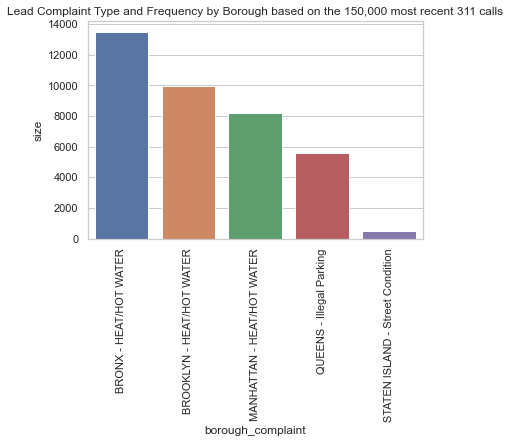

In [198]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=lead_complaint.borough_complaint, y=lead_complaint['size'])
ax.set_title('Lead Complaint Type and Frequency by Borough based on the 150,000 most recent 311 calls')
ax.tick_params(axis='x', rotation=90)

Analysis - 
The leading complaint type by borough and the total amount of calls made based on the 150,000 most recent calls. Heat/Hot Water complaint is the lead complaint type in the 3 boroughs of Bronx, Manhattan, and Brooklyn. The leading complaint type in Queens is illegal parking.